In [37]:
import pandas as pd
import numpy as np
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

from collections import defaultdict

from re import compile

plt.style.use('ggplot')

In [2]:
from tensorflow.config.experimental import list_physical_devices
print("Num CPUs Available: ", len(list_physical_devices('CPU')))
print(device_lib.list_local_devices())

Num CPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2896545471650852869
]


## Parameters

In [44]:
sent_tokenizer = False # S
use_pretrained_embeddings = True

use_nltk_cleaning = False
text_cleaning = True

use_tfidf_tokenizer = True
use_keras_tokenizer = False

use_tfidf_as_embedding_weights = True

## Functions

In [45]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
        """
            text: a string

            return: modified initial string
        """
        text = text.lower() # lowercase text
        text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
        text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
        text = text.replace('x', '')
        text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
        return text


## Data Ingest

## Use 5 Category Data

In [46]:
data_dir = 'D:/Data_Science/ClassificationProblems/Sentiment_Analysis/data/SA_4_Categories.csv'
corpus = pd.read_csv(data_dir ,encoding='latin-1', sep = ';')

## Use 2 Category Data

In [54]:
current_path = getcwd()

filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []

for source, filepath in filepath_dict.items():
    
    df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.rename(columns = {'sentence':'text'}, inplace = True)
corpus = df

In [55]:
corpus.head()

,text,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [56]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2748 non-null   object
 1   label   2748 non-null   int64 
 2   source  2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


## 0. Text Cleaning

In [57]:
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')

In [58]:
corpus.head()

,text,label,source
0,wow loved place,1,yelp
1,crust good,0,yelp
2,tasty teture nasty,0,yelp
3,stopped late may bank holiday rick steve recom...,1,yelp
4,selection menu great prices,1,yelp


## 1. NLTK - Data preprocessing

- I. Remove Blank rows in Data, if any
- II. Change all the text to lower case
- III. Word Tokenization
- IV. Remove Stop words
- V. Remove Non-alpha text
- VI. Word Lemmatization

In [59]:
if use_nltk_cleaning:

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        corpus['text'] = [sent_tokenize(x) for x in corpus['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        corpus['text'] = [word_tokenize(x) for x in corpus['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(corpus['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        corpus.loc[index,'text_clean'] = ' '.join(lemma_words)
    
    corpus.loc[:,'text'] = corpus['text_clean']

## 2. Prepare Trainig and Test data

In [60]:
# Get training X data
sentences = corpus['text'].values

# Use Label encoder for the expected output
Encoder = LabelEncoder()
encoded_Y = Encoder.fit_transform(corpus['label'].values)
Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, Y, test_size=0.25)

In [61]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2748, 2)


## 3. Word Tokenizer 

In [62]:
# Hyperparameters
sent_tokenizer = False
use_nltk_cleaning = False
use_tfidf_tokenizer = False # TODO: Adjust for input to CNN
use_keras_tokenizer = True
use_pretrained_embeddings = True
use_tfidf_as_embedding_weights = True

# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50

In [63]:
if use_keras_tokenizer:
    
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=5000)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
    
    
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab = tokenizer.word_index

    X_train = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test = pad_sequences(X_test, padding='post', maxlen=seq_input_len)

if use_tfidf_tokenizer:
    
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(Corpus['text'])

    # Transfor both the train and the test to document-term matrix
    X_train = Tfidf_vect.transform(sentences_train)
    X_test = Tfidf_vect.transform(sentences_test)
    
    vocab = Tfidf_vect.vocabulary_
    
    vocab_size = len(vocab) + 1
    

## 4. Use pre-trained Embedding Space ( GloVe )

In [64]:
if use_tfidf_as_embedding_weights: 
     
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(corpus['text'])

    # Transfor both the train and the test to document-term matrix
    embedding_matrix = Tfidf_vect.transform(sentences_train)
    
    # Calculate embedding dimension - sequence length
    embedding_dim = len(embedding_matrix.toarray()[1])
    
if use_pretrained_embeddings: 
    
    embedding_dim = 50
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Semillero Data Science/Deep Learning/pre-trained Word Embeddings/GloVe/glove.6B.50d.txt',
     word_index = vocab, 
     embedding_dim = embedding_dim)

## 4. Set up CNN Model 

In [65]:
del model

In [66]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 128, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 50)            212700    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 49, 128)           12928     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 47, 32)            12320     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 22        
Total params: 238,300
Trainable params: 25,600
Non-trainable params: 212,700
___________________________________________

## 6. Run Model - CNN

Wall time: 0 ns
Training Accuracy: 0.9985
Testing Accuracy:  0.7875


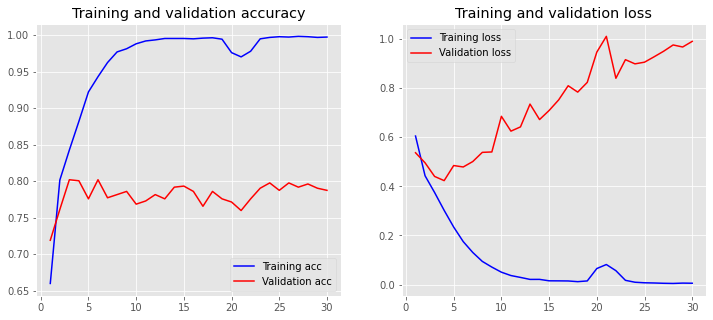

In [67]:
%time

history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [68]:
Y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  76.5  %
Accuracy for label 1 :  81.07  %


{0: 76.5, 1: 81.07}

## 7. Run Model - Recurrent Neural Networks - RNN

Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [69]:
del model

In [70]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Training Accuracy: 0.5211
Testing Accuracy:  0.5022


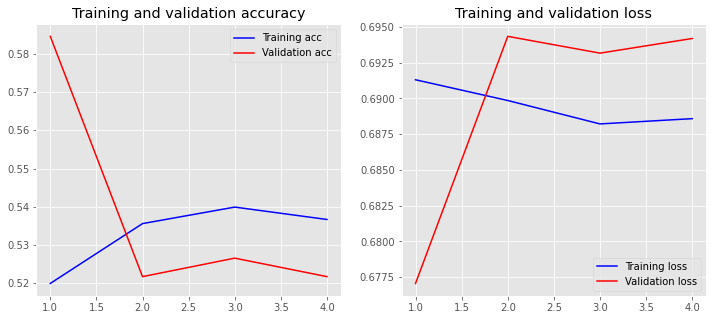

In [71]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test), 
                    validation_split=0.1,
                    verbose = False,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [72]:
Y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  4.3  %
Accuracy for label 1 :  97.63  %


{0: 4.3, 1: 97.63}

In [73]:
# Hyperparameters

sent_tokenizer = False

use_nltk_cleaning = False

use_tfidf_tokenizer = False # TODO: Adjust for input to CNN
use_keras_tokenizer = True

use_pretrained_embeddings = True
use_tfidf_as_embedding_weights = True

# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

In [74]:
def keras_tokenizer(sentences_train, sentences_test, num_words, seq_input_len):

    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words = num_words)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
    X_test = tokenizer.texts_to_sequences(sentences_test)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

    vocab = tokenizer.word_index

    X_train = pad_sequences(X_train, padding = 'post', maxlen = seq_input_len)
    X_test = pad_sequences(X_test, padding = 'post', maxlen = seq_input_len)

    return X_train, X_test, vocab_size, vocab



def tfidf_tokenizer(sentences_train, sentences_test, num_words):

    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=num_words)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(Corpus['text'])

    # Transfor both the train and the test to document-term matrix
    X_train = Tfidf_vect.transform(sentences_train)
    X_test = Tfidf_vect.transform(sentences_test)

    vocab = list(Tfidf_vect.vocabulary_.keys())

    vocab_size = len(vocab) + 1

    return X_train, X_test, vocab_size, vocab 

def create_tfidf_embedding_weights(num_words, sentences_train):

    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features = num_words)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(Corpus['text'])

    # Transfor both the train and the test to document-term matrix
    embedding_matrix = Tfidf_vect.transform(sentences_train)

    # Calculate embedding dimension - sequence length
    embedding_dim = len(embedding_matrix.toarray()[1])

    return embedding_matrix, embedding_dim

In [75]:
param_grid = dict(num_filters_cv = [(128,32), (64,16), (128,32), (128,16)],
                  kernel_size_cv1 = [(2,3), (4,5), (5,4), (5,2)],
                  vocab_size = [5000, 3000, 6000], 
                  embedding_dim = [50],
                  seq_input_len = [50, 40, 30])

In [76]:
# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
embedding_dim = 50
file_path = 'D:/Semillero Data Science/Deep Learning/pre-trained Word Embeddings/GloVe/glove.6B.50d.txt'

def create_model(num_filters_cv, kernel_size_cv, vocab_size, 
                 embedding_dim, seq_input_len, output_label, 
                 use_keras_tokenizer = True, use_tfidf_tokenizer = False, use_tfidf_as_embedding_weights = True ):
    """
    """      

    if use_keras_tokenizer:
        X_train, X_test, vocab_size, vocab = keras_tokenizer(sentences_train, sentences_test, num_words, seq_input_len)

    if use_tfidf_tokenizer:
        X_train, X_test, vocab_size, vocab = tfidf_tokenizer(sentences_train, sentences_test, num_words)
    
    if use_tfidf_as_embedding_weights: 
        embedding_matrix, embedding_dim = create_tfidf_embedding_weights(num_words, sentences_train)

    
    if use_pretrained_embeddings:     
        embedding_matrix = create_embedding_matrix(
                             filepath = filepath,
                             word_index = vocab, 
                             embedding_dim = embedding_dim)
    
    #------------------------------------------------------------#
    #---------- Create CNN Model---------------------------------#
    #------------------------------------------------------------#
    
    model = Sequential()

    if use_pretrained_embeddings:  

        model.add(layers.Embedding(input_dim = vocab_size, 
                                   output_dim = embedding_dim, 
                                   weights = [embedding_matrix], 
                                   input_length = seq_input_len, 
                                   trainable = False))
    else: 
        
        # embedding_dim = 100 # Output Dimension - seq output length
        
        model.add(layers.Embedding(input_dim = vocab_size, 
                                   output_dim = embedding_dim, 
                                   input_length = seq_input_len))

    # Filters: No. of output filter in the convolution
    # kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
    model.add(layers.Conv1D(filters = num_filters_cv[0], kernel_size = kernel_size_cv[0], activation='relu'))

    # Global max pooling operation for 1D temporal data.
    # Downsamples the input representation by taking the maximum value over the time dimension
    #model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Conv1D(filters = num_filters_cv[1], kernel_size = kernel_size_cv[1], activation='relu'))

    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(output_label, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    return model

In [77]:
# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

model = KerasClassifier(build_fn = create_model,
                        epochs = epochs, 
                        batch_size = batch_size,
                        verbose = False)

grid = RandomizedSearchCV(estimator = model, 
                          param_distributions = param_grid,
                          cv = 4, 
                          verbose = 1, 
                          n_iter = 5)

grid_result = grid.fit(X_train, y_train)

Y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)

label_acc = cal_label_accuracy(conf_matrix, verbose  = 1)

with open(output_file, 'a') as f:
    
    s = ('Running {} data set\nBest Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    
    output_string = s.format(
                        source,
                        grid_result.best_score_,
                        grid_result.best_params_,
                        test_accuracy)
    
    print(output_string)
    
    f.write(output_string)

NameError: name 'y_train' is not defined